# Run simulations

In [1]:
# Add project root to Python path
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

# Import necessary libraryes
import joblib
import numpy as np
import pandas as pd
import plotnine as p9
import psutil
from src.population_density_networks import model

## Modeling Parameters

In [2]:
# Fixed global parameters
N = 1000
RADIUS = 1.0

# Varying parameters
DENSITIES = np.logspace(-5, 5, 21, base=10)
K_CAP_MEANS = np.arange(5, 101, 5)
K_CAP_COV = 0.5   # 50% coefficient of variation

# Simulation parameters
SIMULATION_ROUNDS = None  #set during simulation run as 2 * N * K_CAP_MEAN
SIMULATION_REPLICATES = 50
N_JOBS = psutil.cpu_count(logical=True) - 1

## Run Simulations

In [ ]:
#####################
# Define simulation function
#####################
def run_single_simulation(density, replicate, n, k_cap_mean, k_cap_sd, radius, simulation_rounds):
    """Run a single simulation and return results as a dictionary."""
    # Initialize model
    model_run = model.NetworkFormationModel(
        n=n,
        k_cap_mean=k_cap_mean,
        k_cap_sd=k_cap_sd,
        radius=radius,
    )
    model_run.set_up_world(density=density)
    
    # Run simulation
    model_run.create_social_network(rounds=simulation_rounds, show_progress=False)
    
    # Analyze network structure
    network_structure = model.analyze_network_structure(model_run.social_network)
    
    # Create result dictionary
    result_dict = {
        'n': n,
        'k_cap_mean': k_cap_mean,
        'k_cap_sd': k_cap_sd,
        'radius': radius,
        'simulation_rounds': simulation_rounds,
        'population_density': density,
        'replicate': replicate,
    }
    result_dict.update(network_structure.to_dict())
    return result_dict

    
#####################
# Run simulations
#####################
# Vary both density and k_cap_mean, and calculate simulation_rounds = 2 * N * k_cap_mean
param_combinations = [
    (
        density, 
        replicate, 
        N, 
        k_cap_mean, 
        K_CAP_COV * k_cap_mean,  # K_CAP_SD = 0.5 * K_CAP_MEAN
        RADIUS, 
        2 * N * k_cap_mean  # SIMULATION_ROUNDS = 2 * N * K_CAP_MEAN
    )
    for k_cap_mean in K_CAP_MEANS
    for density in DENSITIES
    for replicate in range(SIMULATION_REPLICATES)
]

print(f"🚀 Running {len(param_combinations)} simulations in parallel...")

# Run simulations in parallel
parallel_jobs = min(N_JOBS, len(param_combinations))
results_list = joblib.Parallel(n_jobs=parallel_jobs, verbose=10)(
    joblib.delayed(run_single_simulation)(*params) for params in param_combinations
)

# Convert results to DataFrame
results = pd.DataFrame(results_list)

🚀 Running 21000 simulations in parallel...


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done   6 tasks      | elapsed:    7.7s
[Parallel(n_jobs=13)]: Done  15 tasks      | elapsed:   14.3s
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:   14.5s
[Parallel(n_jobs=13)]: Done  35 tasks      | elapsed:   21.1s
[Parallel(n_jobs=13)]: Done  46 tasks      | elapsed:   27.9s
[Parallel(n_jobs=13)]: Done  59 tasks      | elapsed:   34.8s
[Parallel(n_jobs=13)]: Done  72 tasks      | elapsed:   41.5s
[Parallel(n_jobs=13)]: Done  87 tasks      | elapsed:   48.3s
[Parallel(n_jobs=13)]: Done 102 tasks      | elapsed:   55.3s
[Parallel(n_jobs=13)]: Done 119 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 136 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 155 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:  1.6min
[Parallel(n_jobs=13)]: Done 195 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 216 tasks      | elapsed:  

In [74]:
#####################
# Save results
#####################
results.to_csv('../output/full_parameter_sweep_results.csv', index=False)

results

,n,k_cap_mean,k_cap_sd,radius,simulation_rounds,population_density,replicate,network_density,network_is_connected,network_num_components,network_largest_component_size,network_avg_shortest_path,network_diameter,network_clustering_coef,network_modularity,network_assortativity
0,1000,5,2.5,1.0,10000,0.00001,0,0.004334,False,14,987,5.149871,12,0.052401,0.606957,-0.068451
1,1000,5,2.5,1.0,10000,0.00001,1,0.004505,False,18,983,5.008455,9,0.038710,0.599747,-0.013756
2,1000,5,2.5,1.0,10000,0.00001,2,0.004511,False,12,989,4.977954,10,0.053472,0.595305,-0.052559
3,1000,5,2.5,1.0,10000,0.00001,3,0.004416,False,15,986,5.163067,10,0.055920,0.628053,-0.075856
4,1000,5,2.5,1.0,10000,0.00001,4,0.004513,False,7,994,5.081066,10,0.054481,0.610362,-0.037547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,1000,100,50.0,1.0,200000,100000.00000,45,0.097307,True,1,1000,1.908613,3,0.125013,0.108205,0.134462
20996,1000,100,50.0,1.0,200000,100000.00000,46,0.095530,True,1,1000,1.912438,3,0.125886,0.114049,0.160662
20997,1000,100,50.0,1.0,200000,100000.00000,47,0.096777,True,1,1000,1.910623,3,0.126345,0.103945,0.160863
20998,1000,100,50.0,1.0,200000,100000.00000,48,0.095347,True,1,1000,1.913445,3,0.123582,0.110300,0.159259


## Preliminary analysis of results
More in-depth plotting will be done in R.

In [101]:
#####################
# Calculate averages + simulation ranges for all network metrics
#####################
# Select simulation set
k_cap = 100
results_filtered = results[results['k_cap_mean'] == k_cap]

# Get all network metric columns (exclude boolean columns from quantile calculations)
network_metric_cols = [
    'network_density',
    'network_num_components', 'network_largest_component_size', 
    'network_avg_shortest_path', 'network_diameter',
    'network_clustering_coef', 'network_modularity',
    'network_assortativity'
]

# Define aggregation functions
def quantile_lower(x):
    return x.quantile(0.1)

def quantile_upper(x):
    return x.quantile(0.9)

# Create aggregation dictionary for all numeric network columns
agg_dict = {
    col: ['mean', 'std', 'median', quantile_lower, quantile_upper]
    for col in network_metric_cols
}

# Calculate statistics
summarized_stats = (
    results_filtered[['population_density'] + network_metric_cols]
    .groupby('population_density')
    .agg(agg_dict)
    .reset_index()
)

# Flatten multi-index columns
# The columns will be: population_density, then for each metric: mean, std, quantile_lower, quantile_upper
flat_cols = ['population_density']
for col in network_metric_cols:
    flat_cols.extend([f'{col}_mean', f'{col}_std', f'{col}_median', f'{col}_quantile_lower', f'{col}_quantile_upper'])
summarized_stats.columns = flat_cols

summarized_stats



,population_density,network_density_mean,network_density_std,network_density_median,network_density_quantile_lower,network_density_quantile_upper,network_num_components_mean,network_num_components_std,network_num_components_median,network_num_components_quantile_lower,...,network_modularity_mean,network_modularity_std,network_modularity_median,network_modularity_quantile_lower,network_modularity_quantile_upper,network_assortativity_mean,network_assortativity_std,network_assortativity_median,network_assortativity_quantile_lower,network_assortativity_quantile_upper
0,0.000010,0.080050,0.000997,0.080044,0.078911,0.081437,1.0,0.0,1.0,1.0,...,0.316493,0.017004,0.316481,0.296618,0.338675,0.065070,0.007453,0.064972,0.054149,0.076080
1,0.000032,0.080315,0.001056,0.080359,0.079000,0.081480,1.0,0.0,1.0,1.0,...,0.316034,0.015879,0.314896,0.296254,0.334803,0.064413,0.008558,0.064018,0.053770,0.075840
2,0.000100,0.080339,0.001143,0.080284,0.078943,0.081863,1.0,0.0,1.0,1.0,...,0.309346,0.014776,0.306652,0.292914,0.330309,0.067860,0.009531,0.068317,0.055442,0.081041
3,0.000316,0.081110,0.001080,0.080896,0.079920,0.082231,1.0,0.0,1.0,1.0,...,0.309919,0.014459,0.305706,0.294087,0.331111,0.068483,0.007997,0.069449,0.059056,0.078002
4,0.001000,0.081579,0.001158,0.081485,0.080107,0.082982,1.0,0.0,1.0,1.0,...,0.311959,0.016894,0.314531,0.293425,0.331430,0.070124,0.008652,0.070273,0.058758,0.080908
5,0.003162,0.082467,0.000970,0.082477,0.081089,0.083526,1.0,0.0,1.0,1.0,...,0.309012,0.014919,0.305440,0.292710,0.327424,0.074135,0.008025,0.075080,0.062941,0.083417
6,0.010000,0.083764,0.001045,0.083697,0.082601,0.085044,1.0,0.0,1.0,1.0,...,0.311356,0.018388,0.310410,0.287990,0.337213,0.082411,0.008868,0.081244,0.072924,0.095646
7,0.031623,0.085368,0.000987,0.085415,0.084209,0.086541,1.0,0.0,1.0,1.0,...,0.307287,0.016530,0.306438,0.286900,0.327464,0.093611,0.009073,0.093453,0.084438,0.104982
8,0.100000,0.087104,0.001120,0.087184,0.085716,0.088276,1.0,0.0,1.0,1.0,...,0.298663,0.016037,0.298406,0.279403,0.318951,0.103119,0.007057,0.103112,0.093213,0.112009
9,0.316228,0.088880,0.001134,0.088902,0.087403,0.090012,1.0,0.0,1.0,1.0,...,0.291239,0.014991,0.289623,0.273691,0.311040,0.114057,0.006559,0.114625,0.104647,0.122650


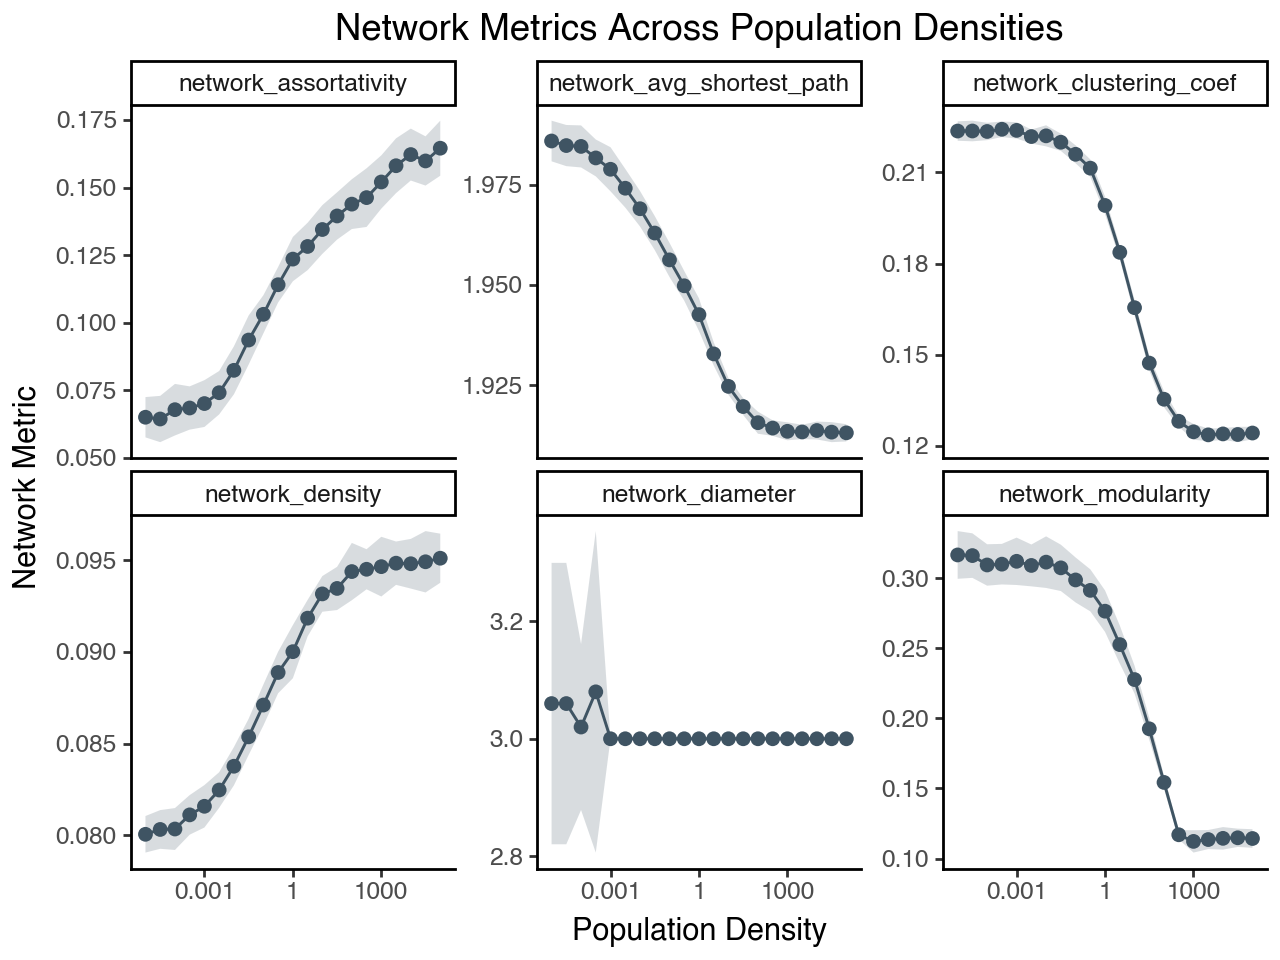

In [102]:
#####################
# Plot
#####################
from plotnine import (
    ggplot, aes, geom_point, geom_line, geom_ribbon, facet_wrap, labs, scale_x_continuous, theme_classic
)
import pandas as pd

# Melt summarized_stats for facetting
metrics_long = pd.melt(
    summarized_stats,
    id_vars=['population_density'],
    value_vars=[
        'network_density_mean', 'network_num_components_mean', 'network_largest_component_size_mean',
        'network_avg_shortest_path_mean', 'network_diameter_mean',
        'network_clustering_coef_mean', 'network_modularity_mean', 'network_assortativity_mean'
    ],
    var_name='metric', value_name='dummy'  # We will overwrite this, just a trick for index expansion
)

# Instead, we want: one row for each metric, with columns for mean, lower, upper
plot_df = pd.DataFrame()
for metric in [
        'network_density',
        'network_avg_shortest_path', 'network_diameter',
        'network_clustering_coef', 'network_modularity', 'network_assortativity'
    ]:
    tmp = summarized_stats[['population_density',
                      f'{metric}_mean',
                      f'{metric}_median',
                      f'{metric}_std',
                      f'{metric}_quantile_lower',
                      f'{metric}_quantile_upper']].copy()
    tmp[f'{metric}_std_lower'] = tmp[f'{metric}_mean'] - tmp[f'{metric}_std']
    tmp[f'{metric}_std_upper'] = tmp[f'{metric}_mean'] + tmp[f'{metric}_std']
    tmp['metric'] = metric
    tmp = tmp.rename(columns={
        f'{metric}_mean': 'mean',
        f'{metric}_median': 'median',
        f'{metric}_std': 'std',
        f'{metric}_quantile_lower': 'lower',
        f'{metric}_quantile_upper': 'upper',
        f'{metric}_std_lower': 'std_lower',
        f'{metric}_std_upper': 'std_upper'
    })
    plot_df = pd.concat([plot_df, tmp], ignore_index=True)

# Plot
graph_color = '#3f5463'
p = (
    ggplot(plot_df, aes(x='population_density', y='mean'))
    + geom_ribbon(aes(ymin='std_lower', ymax='std_upper'), alpha=0.2, fill=graph_color)
    + geom_line(size=0.6, color=graph_color)
    + geom_point(stroke=0, size=3, color=graph_color)
    + scale_x_continuous(trans='log10')
    + facet_wrap('~metric', scales='free_y')
    + labs(
        x='Population Density',
        y='Network Metric',
        title='Network Metrics Across Population Densities'
    )
    + theme_classic()
)
p
